# Notebook for the project in *TDT4259 - Applied Data Science*

Necessary imports

In [8]:
import sys
import os
from datetime import datetime, timedelta

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
sys.path.append(".")

from util.util import get_dataset, clean_attrition_dataset, create_additional_columns, remove_duplicates_and_fill_na

We start by preprocessing the columns to be on a concise format.

In [9]:
raw_dataset = get_dataset("train_data.csv")
cleaned_dataset = clean_attrition_dataset(raw_dataset)
dataset_with_more_cols = create_additional_columns(cleaned_dataset)
final_dataset = remove_duplicates_and_fill_na(dataset_with_more_cols)
final_dataset["Work_Duration"] = (final_dataset.Last_Working_Date - final_dataset.Date_Of_Joining).dt.days

In [4]:
final_dataset.head()

,Date,Attrition,Emp_ID,Age,Gender,City,Education_Level,Salary,Date_Of_Joining,Last_Working_Date,Joining_Designation,Designation,Total_Business_Value,Quarterly_Rating,Work_Duration
2,2016-03-01,1,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2,78
4,2017-12-01,0,2,31,Male,C7,Master,67016,2017-11-06,2017-12-31,2,2,0,1,55
9,2017-04-01,1,4,43,Male,C13,Master,65603,2016-12-07,2017-04-27,2,2,0,1,141
12,2016-03-01,1,5,29,Male,C9,College,46368,2016-01-09,2016-03-07,1,1,0,1,58
17,2017-12-01,0,6,31,Female,C11,Bachelor,78728,2017-07-31,2017-12-31,3,3,0,2,153


Descriptive statistics:

In [18]:
desc = final_dataset.describe()
desc

,Attrition,Emp_ID,Age,Salary,Joining_Designation,Designation,Total_Business_Value,Quarterly_Rating,Work_Duration
count,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000
mean,0.678706,1397.559009,33.663167,59334.157077,1.820244,2.096598,2.667694e+05,1.427971,437.117178
std,0.467071,806.161628,5.983375,28383.666384,0.841433,0.941522,1.134681e+06,0.809839,567.638730
min,0.000000,1.000000,21.000000,10747.000000,1.000000,1.000000,-9.900000e+05,1.000000,0.000000
25%,0.000000,695.000000,29.000000,39104.000000,1.000000,1.000000,0.000000e+00,1.000000,99.000000
50%,1.000000,1400.000000,33.000000,55315.000000,2.000000,2.000000,0.000000e+00,1.000000,192.000000
75%,1.000000,2100.000000,37.000000,75986.000000,2.000000,3.000000,1.969200e+05,2.000000,480.000000
max,1.000000,2788.000000,58.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000,2831.000000


<AxesSubplot:xlabel='Attrition', ylabel='count'>

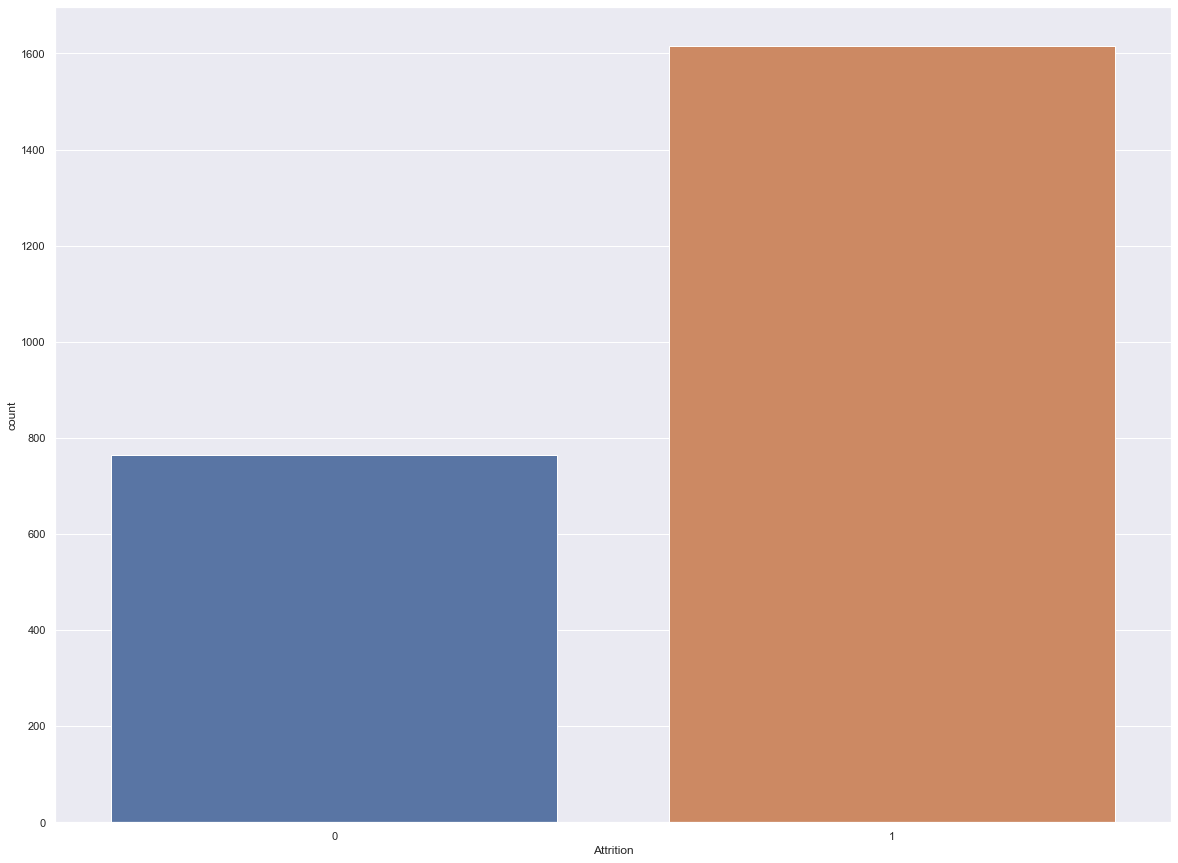

In [17]:
sns.set(rc = {"figure.figsize": (20, 15)})
sns.countplot(final_dataset, x = "Attrition")

Model prototyping

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [5]:
final_dataset = pd.get_dummies(final_dataset, columns=["Gender", "City", "Education_Level"])

In [6]:
final_dataset.head()

,Date,Attrition,Emp_ID,Age,Salary,Date_Of_Joining,Last_Working_Date,Joining_Designation,Designation,Total_Business_Value,...,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9,Education_Level_Bachelor,Education_Level_College,Education_Level_Master
2,2016-03-01,1,1,28,57387,2015-12-24,2016-03-11,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,2017-12-01,0,2,31,67016,2017-11-06,2017-12-31,2,2,0,...,0,0,0,0,1,0,0,0,0,1
9,2017-04-01,1,4,43,65603,2016-12-07,2017-04-27,2,2,0,...,0,0,0,0,0,0,0,0,0,1
12,2016-03-01,1,5,29,46368,2016-01-09,2016-03-07,1,1,0,...,0,0,0,0,0,0,1,0,1,0
17,2017-12-01,0,6,31,78728,2017-07-31,2017-12-31,3,3,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
X_data = final_dataset.drop(columns=["Attrition", "Date", "Date_Of_Joining", "Last_Working_Date", "Emp_ID"], axis = 1)
y_data = final_dataset["Attrition"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=4259)

In [9]:
log = LogisticRegression()
log.fit(X_train, y_train)
log_pred = log.predict(X_test)

print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           0       0.83      0.51      0.63       153
           1       0.80      0.95      0.87       324

    accuracy                           0.81       477
   macro avg       0.82      0.73      0.75       477
weighted avg       0.81      0.81      0.79       477



In [10]:
print(log.coef_, log.intercept_)

[[ 5.24363774e-02 -5.45374831e-06  5.94129135e-04  5.42551354e-04
  -5.07271539e-06  9.06049885e-04  3.31201655e-04  7.02591293e-04
   9.27966148e-04  3.55363677e-05  1.30866817e-04  4.12926937e-05
   1.60612393e-05  1.46484815e-04  6.34496682e-05  2.70872381e-05
  -5.29604113e-06  1.58798347e-04  8.60497963e-05 -4.20779171e-05
   1.56589529e-04  9.20480756e-05  2.94285367e-05  3.41263441e-05
   8.82046795e-05  1.01054248e-04  3.06688910e-05  6.67012933e-05
   7.87168481e-06  1.39956459e-04 -2.32116359e-05  1.34846928e-05
   5.62077008e-05 -5.59702127e-07  2.64868056e-05  1.21833482e-04
  -1.40739890e-05  4.54873218e-05  4.62894173e-04  7.44922664e-04
   4.22740604e-04]] [0.00163056]


In [11]:
svc = SVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.79      0.60      0.68       153
           1       0.83      0.92      0.87       324

    accuracy                           0.82       477
   macro avg       0.81      0.76      0.78       477
weighted avg       0.82      0.82      0.81       477



In [12]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)

print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           0       0.77      0.65      0.70       153
           1       0.85      0.91      0.88       324

    accuracy                           0.83       477
   macro avg       0.81      0.78      0.79       477
weighted avg       0.82      0.83      0.82       477

